In [1]:
# Import all the neccessary libraries
import pandas as pd
import geopandas as gpd
from folium import Map, Marker, Circle
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
import seaborn as sns
import webbrowser
import requests

In [26]:
# Initalize the OData URL
odata_url = 'https://data.lacity.org/api/odata/v4/2nrs-mtv8'

# Set display option to show all columns

pd.set_option('display.max_columns', None)

In [3]:
# Initialize an empty list to store all data frames
all_data = []

while odata_url:
    # Make a request to the OData URL
    response = requests.get(odata_url)
    data = response.json()

    # Convert the 'value' part of the response to a Dataframe and append it to the list
    df = pd.DataFrame(data['value'])
    all_data.append(df)

    # Check if there is a next page 
    odata_url = data.get('@odata.nextLink')


# Concatenate all data frames into a single DataFrame
crime_data = pd.concat(all_data, ignore_index=True)

crime_data_copy = crime_data.copy()

In [4]:
crime_data_copy = crime_data.copy()

In [5]:
# Drop __id column as it is irrelevant for the analysis and crm_cd_1 and crm_cd are the same (according to data definition). 

crime_data_copy.drop(['__id', 'crm_cd_1'], axis=1, inplace=True)

In [6]:
crime_data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 951608 entries, 0 to 951607
Data columns (total 27 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   dr_no           951608 non-null  object 
 1   date_rptd       951608 non-null  object 
 2   date_occ        951608 non-null  object 
 3   time_occ        951608 non-null  object 
 4   area            951608 non-null  object 
 5   area_name       951608 non-null  object 
 6   rpt_dist_no     951608 non-null  object 
 7   part_1_2        951608 non-null  int64  
 8   crm_cd          951608 non-null  object 
 9   crm_cd_desc     951608 non-null  object 
 10  mocodes         816159 non-null  object 
 11  vict_age        951608 non-null  object 
 12  vict_sex        822716 non-null  object 
 13  vict_descent    822706 non-null  object 
 14  premis_cd       951597 non-null  float64
 15  premis_desc     951040 non-null  object 
 16  weapon_used_cd  324847 non-null  object 
 17  weapon_des

## Data Cleaning Process

In [7]:
# Convert columns from string to int

columns_to_convert_to_int = ['dr_no', 'area' ,'rpt_dist_no', 'part_1_2', 'crm_cd', 'vict_age', 'premis_cd']

for int_column in columns_to_convert_to_int:
    crime_data_copy[int_column] = pd.to_numeric(crime_data_copy[int_column])

# Convert object data types to datetime

columns_to_convert_to_datetime = ['date_rptd', 'date_occ']
for dt_column in columns_to_convert_to_datetime:
    crime_data_copy[dt_column] = pd.to_datetime(crime_data_copy[dt_column])

In [8]:
crime_data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 951608 entries, 0 to 951607
Data columns (total 27 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   dr_no           951608 non-null  int64         
 1   date_rptd       951608 non-null  datetime64[ns]
 2   date_occ        951608 non-null  datetime64[ns]
 3   time_occ        951608 non-null  object        
 4   area            951608 non-null  int64         
 5   area_name       951608 non-null  object        
 6   rpt_dist_no     951608 non-null  int64         
 7   part_1_2        951608 non-null  int64         
 8   crm_cd          951608 non-null  int64         
 9   crm_cd_desc     951608 non-null  object        
 10  mocodes         816159 non-null  object        
 11  vict_age        951608 non-null  int64         
 12  vict_sex        822716 non-null  object        
 13  vict_descent    822706 non-null  object        
 14  premis_cd       951597 non-null  flo

In [9]:
# Rename the columns in clear wording
crime_data_copy.rename(
    columns={
        'dr_no': 'Division of Records Number',
        'date_rptd': 'Reported Date',
        'date_occ': 'Occurance Date',
        'time_occ': 'Occurance Time',
        'area': 'Area',
        'area_name': 'Area Name',
        'rpt_dist_no': 'Reporting District Number',
        'part_1_2': 'Part 1 or 2',
        'crm_cd': 'Crime Code',
        'crm_cd_desc': 'Crime Code Description',
        'mocodes': 'Modus Operandi Codes',
        'vict_age': 'Victim Age',
        'vict_sex': 'Victim Sex',
        'vict_descent': 'Victim Descent',
        'premis_cd': 'Premise Code',
        'premis_desc': 'Premise Description',
        'weapon_used_cd': 'Weapon Used Code',
        'weapon_desc': 'Weapon Description',
        'status': 'Case Status',
        'status_desc': 'Case Status Description',
        'crm_cd_2': 'Crime Code 2',
        'crm_cd_3': 'Crime Code 3',
        'crm_cd_4': 'Crime Code 4',
        'location': 'Location',
        'cross_street': 'Cross Street',
        'lat': 'Latitude',
        'lon': 'Longitude'
        
    }, inplace= True
)

In [10]:
# Calculate number of days it took to report a crime
crime_data_copy['Report Delayed in Days'] = (crime_data_copy['Reported Date'] - crime_data_copy['Occurance Date']).dt.days

In [41]:
# Drop victim age less than zero

index_to_drop = crime_data_copy[crime_data_copy['Victim Age'] < 0].index

crime_data_copy.drop(index=index_to_drop, inplace=True)

In [11]:
# Sort dataframe by 'Reported Date' 
crime_data_copy.sort_values(by='Reported Date', inplace=True)

In [12]:
# Set 'Reported Date' as index
crime_data_copy.set_index('Reported Date', inplace=True)



In [13]:
# Count crime per month based on 'Crime Code'
crime_per_month = crime_data_copy['Crime Code'].resample('ME').count()

## 1. Crime Trend Analysis

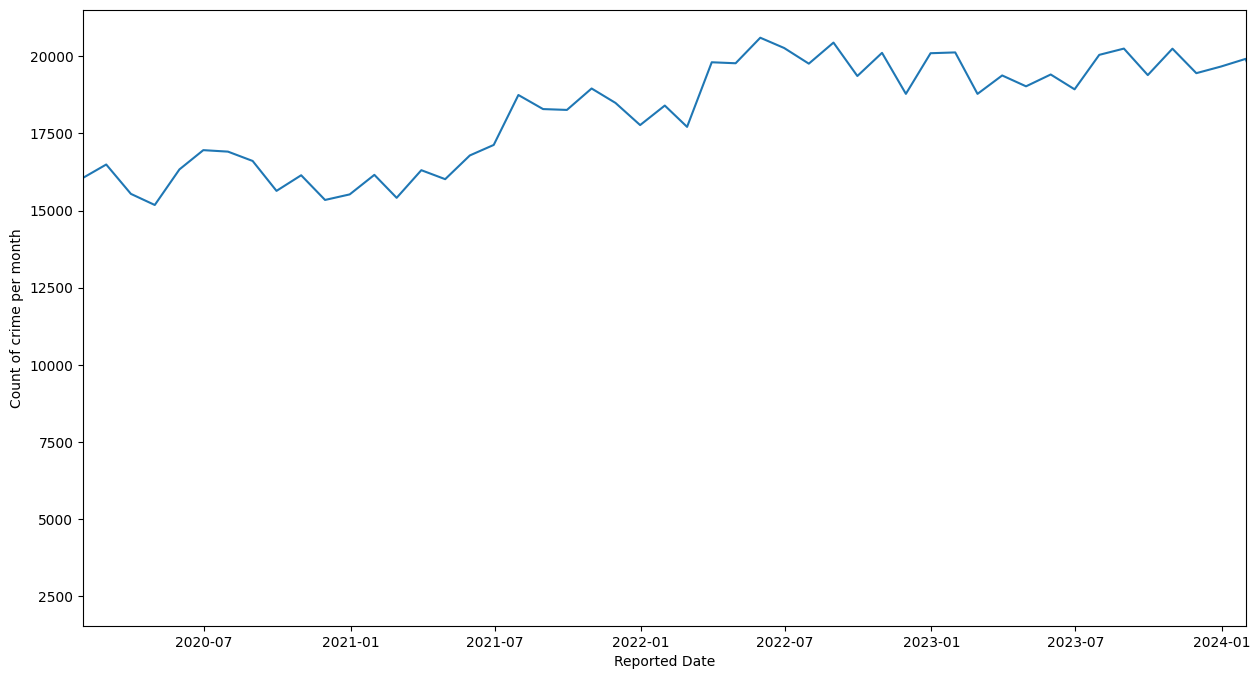

In [14]:
plt.figure(figsize=(15,8))
ax = sns.lineplot(data=crime_per_month)
plt.ylabel('Count of crime per month')
ax.set_xlim(crime_per_month.index[0], pd.to_datetime('2024-01-31'))

plt.show()

## 2. Spatial Analysis of Crimes

In [15]:
# Aggregate the crime reports by area or district, and compute the mean latitude and longitude for each group
grouped_data = crime_data_copy.groupby('Area Name').agg({
    'Latitude': 'mean',
    'Longitude': 'mean',
    'Reporting District Number': 'count'
}).reset_index()

grouped_data

# Generate a list of locations, with the count affecting the intensity in the heatmap
heatmap_data = grouped_data[['Latitude', 'Longitude', 'Reporting District Number']].values.tolist()
heatmap_data = [[row[0], row[1], row[2]] for row in heatmap_data]
# Create and add the heat map layer
crime_map = folium.Map(location=[grouped_data['Latitude'].mean(), grouped_data['Longitude'].mean()], zoom_start=12)
HeatMap(heatmap_data).add_to(crime_map)
# Save the heatmap to an HTML file
crime_map.save('crime_heatmap_by_Area_Name.html')
webbrowser.open('crime_heatmap_by_Area_Name.html')

True

## 3. Victim Profile Analysis

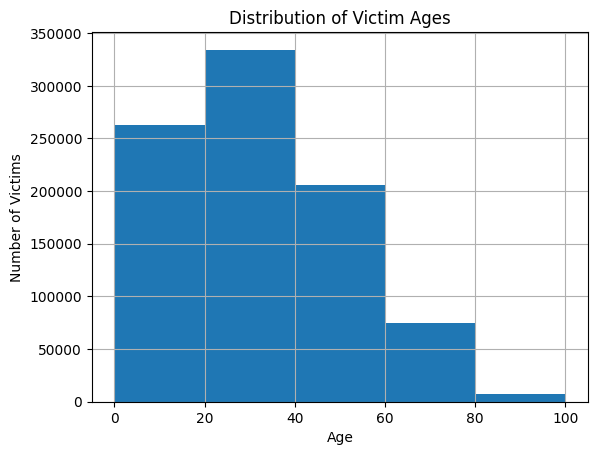

In [40]:
crime_data_copy['Victim Age'].hist(bins=range(0, 101, 20))

plt.title('Distribution of Victim Ages')
plt.xlabel('Age')
plt.ylabel('Number of Victims')
plt.show()